<a href="https://colab.research.google.com/github/ejihoon6065/Project_TurnAround/blob/master/Prophet_2020_10_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 아래 코드를 돌리기전 아래 URL 참고할 것, Prophet모델에 input될 데이터의 상한 하한을 그날의 값의 ±10% 이상은 변동하지 않는 제한을 두는 내용

# 시계열 데이터는 일반적 데이터와는 다르게 순서가 존재하므로 일반적 cross validation 방법으로는  검증이 불가능함 -> one-step forecast validation 사용 
# one-step forecast validation: 시간이 지남에 따라 매일매일 업데이트되는 데이터로 모델을 업데이트하고 그다음 날을 예측하는 프로세스를 반복하는 방법

# https://predictor-ver1.tistory.com/6 
# https://colab.research.google.com/notebooks/snippets/importing_libraries.ipynb 참고

In [2]:
import pandas as pd
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set() # setting seaborn default for plots
import matplotlib.font_manager as fm
import copy
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
import numpy as np


from scipy import stats  # Box-Cox 검정
import statsmodels.api as sm  # qqplot
from statsmodels.tsa.stattools import adfuller    # adfuller : ADF그래프 그려주는 함수
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from statsmodels.stats.diagnostic import acorr_ljungbox # Ljung-Box 검정

import warnings
warnings.filterwarnings("ignore")

import itertools
import copy
from datetime import datetime,timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip # 진행상태바 표시를 위한 tqdm 라이브러리 설치 

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47868 sha256=5987224c6f16d8c5e82da651aba82c5e734b8fdfd480e219acb85f212ad51c19
  Stored in directory: /tmp/pip-ephem-wheel-cache-dbwxysat/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
ERROR: spacy 2.2.4 has requirement tqdm<5.0.0,>=4.38.0, but you'll have tqdm 4.28.1 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement tqdm>=4.36.1, but you'll have tqdm 4.28.1 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
pip install -U pykrx  # KRX데이터를 크롤링하기 위한 라이브러리설치

Requirement already up-to-date: pykrx in /usr/local/lib/python3.6/dist-packages (0.1.41)


In [6]:
from pykrx import stock

today=datetime.today().strftime("%Y%m%d")                      # 현재날짜
year1=(datetime.today()-timedelta(365)).strftime('%Y%m%d')     # 현재날짜로부터 1년전 날짜

df = stock.get_market_ohlcv_by_date(year1,today, "122870") # DataFrame, (시작날짜,종료날짜,종목번호)
df

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-08,23400,23900,22900,23800,148848
2019-10-10,23550,23700,23000,23550,150525
2019-10-11,23800,25200,23650,23950,474910
2019-10-14,24350,25850,24150,25650,558471
2019-10-15,25600,26700,25350,26000,425303
...,...,...,...,...,...
2020-09-28,52300,57500,51800,57000,1067907
2020-09-29,57700,58000,54900,58000,758762
2020-10-05,57100,57400,51800,52500,1428801


In [7]:
# train,test 데이터 나누기

print('df.shape : ',df.shape)

# 조정가능한 값 (validation_size , test_size)
validation_size=40
test_size=10

train=df[:len(df)-validation_size]
validation=df[len(df)-validation_size:len(df)-test_size]
test=df[len(df)-test_size:]

print('train.shape : ',train.shape)
print('validation.shape : ',validation.shape)
print('test.shape : ',test.shape)

df.shape :  (248, 5)
train.shape :  (208, 5)
validation.shape :  (30, 5)
test.shape :  (10, 5)


In [8]:
# 전체적인 주가 데이터 살펴보기
df.describe()

와이지엔터테인먼트,시가,고가,저가,종가,거래량
count,248.000000,248.000000,248.000000,248.000000,2.480000e+02
mean,33411.088710,34296.774194,32569.758065,33480.241935,4.395776e+05
std,9563.247167,9807.722814,9233.246824,9556.998874,5.533485e+05
min,19650.000000,20100.000000,18950.000000,19450.000000,5.555200e+04
25%,26150.000000,26550.000000,25737.500000,26150.000000,2.060082e+05
50%,30525.000000,31375.000000,29875.000000,30575.000000,3.011435e+05
75%,38000.000000,39175.000000,37312.500000,38312.500000,4.841405e+05
max,59300.000000,60500.000000,57500.000000,58700.000000,5.841435e+06


In [9]:
train_data=pd.concat([train,validation],axis=0)
train_data

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-08,23400,23900,22900,23800,148848
2019-10-10,23550,23700,23000,23550,150525
2019-10-11,23800,25200,23650,23950,474910
2019-10-14,24350,25850,24150,25650,558471
2019-10-15,25600,26700,25350,26000,425303
...,...,...,...,...,...
2020-09-14,59300,59300,57500,58000,329573
2020-09-15,57800,58400,57000,58000,270909
2020-09-16,58000,58800,57300,58300,290431


In [10]:
test_data=pd.concat([train_data,test],axis=0)
test_data

와이지엔터테인먼트,시가,고가,저가,종가,거래량
날짜,,,,,
2019-10-08,23400,23900,22900,23800,148848
2019-10-10,23550,23700,23000,23550,150525
2019-10-11,23800,25200,23650,23950,474910
2019-10-14,24350,25850,24150,25650,558471
2019-10-15,25600,26700,25350,26000,425303
...,...,...,...,...,...
2020-09-28,52300,57500,51800,57000,1067907
2020-09-29,57700,58000,54900,58000,758762
2020-10-05,57100,57400,51800,52500,1428801


In [11]:

# Prophet모델에 input되기 위해서는 ['ds','y']로 column형식을 맞춰야 함

train_data=pd.DataFrame({'ds':train_data.index,'y':train_data['종가']})
train_data=train_data.reset_index(drop=True)

#validation['날짜']=validation.index
#validation=pd.DataFrame({'ds':validation['날짜'],'y':validation['종가']})
#validation=validation.reset_index(drop=True)


#test['날짜']=test.index
#test=pd.DataFrame({'y':test['종가']})
#test=test.reset_index(drop=True)

In [12]:
train_data

,ds,y
0,2019-10-08,23800
1,2019-10-10,23550
2,2019-10-11,23950
3,2019-10-14,25650
4,2019-10-15,26000
...,...,...
233,2020-09-14,58000
234,2020-09-15,58000
235,2020-09-16,58300
236,2020-09-17,56300


In [13]:
# 조정가능한 값 (limit_percentage)
limit_percentage=30


train_data['cap'] = train_data['y'].shift() * (1+limit_percentage/100)   # 당일날의 상한(cap), 하한(하한)은 전날 종가의 10%이내로 설정
train_data['floor'] = train_data['y'].shift() * (1-limit_percentage/100)
train_data.fillna(method='bfill', inplace=True)
train_data

,ds,y,cap,floor
0,2019-10-08,23800,30940.0,16660.0
1,2019-10-10,23550,30940.0,16660.0
2,2019-10-11,23950,30615.0,16485.0
3,2019-10-14,25650,31135.0,16765.0
4,2019-10-15,26000,33345.0,17955.0
...,...,...,...,...
233,2020-09-14,58000,76310.0,41090.0
234,2020-09-15,58000,75400.0,40600.0
235,2020-09-16,58300,75400.0,40600.0
236,2020-09-17,56300,75790.0,40810.0


In [14]:
'''
train_diff=train['y'].diff()
train_diff=train_diff.dropna()                # 종가를 1차차분한 값들 -> train_diff

train_data=pd.DataFrame({'ds':train['ds'][1:],'y':train_diff})

plt.figure(figsize=(12, 5))
plt.rcParams['lines.linewidth'] = 1
plt.grid(axis='y')
plt.plot(train_data['ds'],train_data['y'])
plt.title('Stock Price 1 Difference', fontsize=20)
plt.xlabel('Days', fontsize=10)
plt.ylabel('Value', fontsize=10)
#plt.xticks(train_data['ds'], fontsize=10)
plt.show()
'''

"\ntrain_diff=train['y'].diff()\ntrain_diff=train_diff.dropna()                # 종가를 1차차분한 값들 -> train_diff\n\ntrain_data=pd.DataFrame({'ds':train['ds'][1:],'y':train_diff})\n\nplt.figure(figsize=(12, 5))\nplt.rcParams['lines.linewidth'] = 1\nplt.grid(axis='y')\nplt.plot(train_data['ds'],train_data['y'])\nplt.title('Stock Price 1 Difference', fontsize=20)\nplt.xlabel('Days', fontsize=10)\nplt.ylabel('Value', fontsize=10)\n#plt.xticks(train_data['ds'], fontsize=10)\nplt.show()\n"

In [15]:
print(train_data['ds'][0])                  # train_Data의 시작날짜
print(train_data['ds'][len(train_data)-1])  # train_Datad의 끝날짜

2019-10-08 00:00:00
2020-09-18 00:00:00


In [16]:
# 주말, 공휴일의 영향을 고려하기위함. (아직 Doing)
!pip install workalendar
from workalendar.asia import SouthKorea
import datetime\
 
kor_holiday=np.array(SouthKorea().holidays(2019))   # 2019년 한국의 공휴일 날짜가 담긴 array 

def print_whichday(year, month, day) :     # 년-월-일을 입력하면 요일을 말해주는 함수 
    r = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    aday = datetime.date(year, month, day)
    bday = aday.weekday()
    return r[bday]

test_date='2020-10-03'
y, m, d = test_date.split('-')
print(print_whichday(int(y), int(m), int(d)))

토요일


In [17]:
# 출처: https://zamezzz.tistory.com/279 [배워가는블로거]
# Holiday Parameter

national_holidays=['2019-10-09','2019-12-25','2020-01-01','2020-01-24','2020-01-25','2020-01-26','2020-03-01','2020-04-30','2020-05-05','2020-06-06','2020-08-15','2020-08-17']


nationalHolidays = pd.DataFrame({

  'holiday': 'nationalHolidays',

  'ds': pd.to_datetime(['2019-10-09','2019-12-25','2020-01-01','2020-01-24','2020-01-25','2020-01-26','2020-03-01','2020-04-30','2020-05-05','2020-06-06','2020-08-15','2020-08-17']),
  'lower_window': -1,
  'upper_window': 0,
})


'''
updatedays = pd.DataFrame({

  'holiday': 'updatedays',

  'ds': pd.to_datetime(['2018-01-01','',....]),

  'lower_window': 0,

  'upper_window': 1

})
'''



"\nupdatedays = pd.DataFrame({\n\n  'holiday': 'updatedays',\n\n  'ds': pd.to_datetime(['2018-01-01','',....]),\n\n  'lower_window': 0,\n\n  'upper_window': 1\n\n})\n"

In [18]:
from fbprophet import Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot
import itertools

# https://hyperconnect.github.io/2020/03/09/prophet-package.html 참고하여 parameter 조정
# https://zzsza.github.io/data/2019/02/06/prophet/ 참고 

In [19]:
# cp = ARIMA로부터 추정된 changingpoint 리스트 
'''
cp=['2020-08-07',
 '2020-08-11',
 '2020-08-12',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-21',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08',
 '2020-09-15',
 '2020-09-16',
 '2020-09-17']
'''
cp=['2020-08-11',
 '2020-08-12',
 '2020-08-13',
 '2020-08-18',
 '2020-08-19',
 '2020-08-20',
 '2020-08-26',
 '2020-08-28',
 '2020-08-31',
 '2020-09-02',
 '2020-09-03',
 '2020-09-07',
 '2020-09-08',
 '2020-09-17']    # 트레져 앨범 발매일


In [45]:
train_copy=copy.deepcopy(train_data)
train_copy['y']=train_copy['y']*0.001          # scale 변화를 더 크게 하기위해 1000으로 나눠줌
train_copy['cap']=train_copy['cap']*0.001
train_copy['floor']=train_copy['floor']*0.001
train_copy

,ds,y,cap,floor
0,2019-10-08,23.80,30.940,16.660
1,2019-10-10,23.55,30.940,16.660
2,2019-10-11,23.95,30.615,16.485
3,2019-10-14,25.65,31.135,16.765
4,2019-10-15,26.00,33.345,17.955
...,...,...,...,...
233,2020-09-14,58.00,76.310,41.090
234,2020-09-15,58.00,75.400,40.600
235,2020-09-16,58.30,75.400,40.600
236,2020-09-17,56.30,75.790,40.810


In [46]:
import random
random.seed(100)

from tqdm import tqdm_notebook as tqdm
from time import sleep 

for i in tqdm(range(len(test)),desc='tqdm'):
  m=Prophet(                growth = 'logistic',
                            daily_seasonality = True,
                            weekly_seasonality = 'auto',
                            yearly_seasonality = False,
                            changepoints=cp,            # 
                            changepoint_prior_scale=0.4,           # changepoint_prior_scale : 0.05 (default)
                            changepoint_range=0.9,                 # changepoint_range : 0.8 (default)        
                            holidays=nationalHolidays)             # 
  m.fit(train_copy)

  #future=pd.DataFrame({'ds': test.index[i]})
  future =  m.make_future_dataframe(periods=1,freq='D')

  future['cap'] = train_copy['cap'].append(round(pd.Series(train_copy['y'].values[-1]*(1+limit_percentage/100)),3),ignore_index=True)
  future['floor'] = train_copy['floor'].append(round(pd.Series(train_copy['y'].values[-1]*(1-limit_percentage/100)),3),ignore_index=True)
  future.fillna(method='bfill', inplace=True)
  
  forecast = m.predict(future)
  train_copy=copy.deepcopy(forecast)
  train_copy=forecast[['ds','yhat','yhat_upper','yhat_lower']]
  train_copy=train_copy.rename(columns={'ds':'ds','yhat':'y','yhat_upper':'cap','yhat_lower':'floor'})

  print('Error : ',(test['종가'][i]-(list(train_copy['y'])[-1]*1000)),' / yhat : ',list(train_copy['y'])[-1]*1000,' / y : ',test['종가'][i],' / y_고가 : ',test['고가'][i],' / y_저가 : ',test['저가'][i])
  #print(train_copy.tail(10))
  #print()


Error :  -2867.6863157994376  / yhat :  58467.68631579944  / y :  55600  / y_고가 :  58200  / y_저가 :  55500
Error :  -2878.1360738380317  / yhat :  58078.13607383803  / y :  55200  / y_고가 :  56600  / y_저가 :  54500
Error :  -1606.1744390293388  / yhat :  57506.17443902934  / y :  55900  / y_고가 :  56400  / y_저가 :  52500
Error :  -5607.570858949002  / yhat :  57507.570858949  / y :  51900  / y_고가 :  55600  / y_저가 :  51800
Error :  -6614.196577536983  / yhat :  57514.19657753698  / y :  50900  / y_고가 :  52900  / y_저가 :  49400
Error :  -495.6690655323837  / yhat :  57495.669065532384  / y :  57000  / y_고가 :  57500  / y_저가 :  51800
Error :  486.9617596313692  / yhat :  57513.03824036863  / y :  58000  / y_고가 :  58000  / y_저가 :  54900
Error :  -5114.734433233018  / yhat :  57614.73443323302  / y :  52500  / y_고가 :  57400  / y_저가 :  51800
Error :  -6207.664332104636  / yhat :  57707.664332104636  / y :  51500  / y_고가 :  53200  / y_저가 :  50200
Error :  -6238.958864584405  / yhat :  57838.95886458

In [47]:
ds_index=[0]
forecast=forecast.iloc[:, ~forecast.columns.isin(forecast.columns[ds_index])]*1000   #  날짜를 나타내는 열인 'ds'를 제외한 다른 열들에 1000을 곱해줌
forecast['ds']=train_copy['ds']
forecast=forecast[['ds','trend',	'cap',	'floor',	'yhat_lower',	'yhat_upper',	'trend_lower',	'trend_upper',	'additive_terms',	'additive_terms_lower',	'additive_terms_upper',	'daily','daily_lower',	'daily_upper',	'holidays',	'holidays_lower',	'holidays_upper',	'nationalHolidays',	'nationalHolidays_lower',	'nationalHolidays_upper',	'weekly',	'weekly_lower',	'weekly_upper',	'multiplicative_terms',	'multiplicative_terms_lower',	'multiplicative_terms_upper',	'yhat']]

In [48]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
238,2020-09-19,58467.717213,58467.717213,58467.717213
239,2020-09-20,58078.123743,58078.123743,58078.123743
240,2020-09-21,57506.201719,57506.201719,57506.201719
241,2020-09-22,57507.571565,57507.571565,57507.571565
242,2020-09-23,57514.196679,57514.196679,57514.196679
243,2020-09-24,57495.669067,57495.669067,57495.669067
244,2020-09-25,57513.038240,57513.038240,57513.038240
245,2020-09-26,57614.734433,57614.734433,57614.734433
246,2020-09-27,57707.664332,57707.664332,57707.664332
247,2020-09-28,57838.958865,57838.958865,57838.958865


In [49]:
result_pred=forecast[-len(test):]
result_pred

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,nationalHolidays,nationalHolidays_lower,nationalHolidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
238,2020-09-19,58467.717213,58467.717213,58467.717213,58467.717213,58467.717213,58467.717213,58467.717213,3.822456e-11,3.822456e-11,3.822456e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,-3.750624e-12,-3.750624e-12,-3.750624e-12,0.0,0.0,0.0,58467.717213
239,2020-09-20,58078.123743,58078.123743,58078.123743,58078.123743,58078.123743,58078.123743,58078.123743,3.432233e-11,3.432233e-11,3.432233e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,-7.652860e-12,-7.652860e-12,-7.652860e-12,0.0,0.0,0.0,58078.123743
240,2020-09-21,57506.201719,57506.201719,57506.201719,57506.201719,57506.201719,57506.201719,57506.201719,6.293953e-11,6.293953e-11,6.293953e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,2.096434e-11,2.096434e-11,2.096434e-11,0.0,0.0,0.0,57506.201719
241,2020-09-22,57507.571565,57507.571565,57507.571565,57507.571565,57507.571565,57507.571565,57507.571565,8.152403e-11,8.152403e-11,8.152403e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,3.954885e-11,3.954885e-11,3.954885e-11,0.0,0.0,0.0,57507.571565
242,2020-09-23,57514.196679,57514.196679,57514.196679,57514.196679,57514.196679,57514.196679,57514.196679,5.539212e-11,5.539212e-11,5.539212e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,1.341694e-11,1.341694e-11,1.341694e-11,0.0,0.0,0.0,57514.196679
243,2020-09-24,57495.669067,57495.669067,57495.669067,57495.669067,57495.669067,57495.669067,57495.669067,8.253897e-12,8.253897e-12,8.253897e-12,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,-3.372129e-11,-3.372129e-11,-3.372129e-11,0.0,0.0,0.0,57495.669067
244,2020-09-25,57513.038240,57513.038240,57513.038240,57513.038240,57513.038240,57513.038240,57513.038240,1.316984e-11,1.316984e-11,1.316984e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,-2.880535e-11,-2.880535e-11,-2.880535e-11,0.0,0.0,0.0,57513.038240
245,2020-09-26,57614.734433,57614.734433,57614.734433,57614.734433,57614.734433,57614.734433,57614.734433,3.822456e-11,3.822456e-11,3.822456e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,-3.750624e-12,-3.750624e-12,-3.750624e-12,0.0,0.0,0.0,57614.734433
246,2020-09-27,57707.664332,57707.664332,57707.664332,57707.664332,57707.664332,57707.664332,57707.664332,3.432233e-11,3.432233e-11,3.432233e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,-7.652860e-12,-7.652860e-12,-7.652860e-12,0.0,0.0,0.0,57707.664332
247,2020-09-28,57838.958865,75020.000000,40395.000000,57838.958865,57838.958865,57838.958865,57838.958865,6.293953e-11,6.293953e-11,6.293953e-11,4.197519e-11,4.197519e-11,4.197519e-11,0.0,0.0,0.0,0.0,0.0,0.0,2.096434e-11,2.096434e-11,2.096434e-11,0.0,0.0,0.0,57838.958865


In [50]:
result_pred=forecast['yhat'].tail(10)
result_pred_df=pd.DataFrame(result_pred)
result_pred_df.index=test.index

<function matplotlib.pyplot.show>

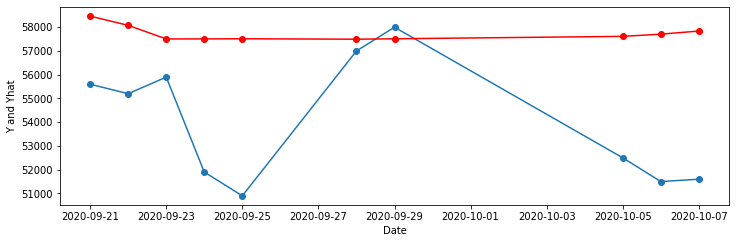

In [51]:
# 실제값만 plot해서 보기
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.plot(test['종가'],marker='o')
ax1.plot(result_pred_df,marker='o',color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y and Yhat')
plt.show

Text(0.5, 1.0, '예측값')

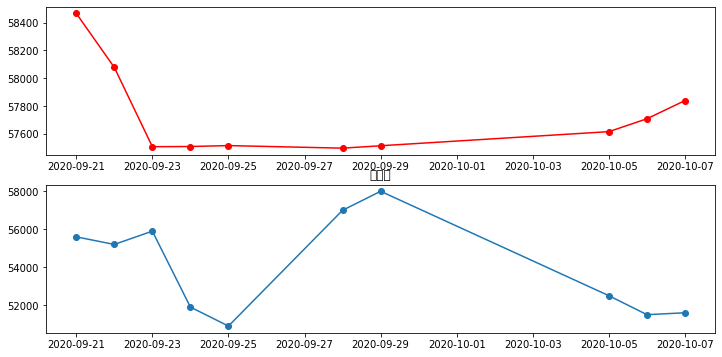

In [52]:
# 예측값, 실제값 따로따로 보기
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot(result_pred_df,marker='o',color='red')
ax2.plot(test['종가'],label='실제값',marker='o')
plt.title('예측값')

In [28]:
'''
fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(211)
ax1.plot(test['종가'],label='실제값')
ax1.plot(result_pred,color='red',label='예측값')
ax1.set_xlabel('Date')
ax1.set_ylabel('Y')
ax1.legend(loc='best')
plt.show
plt.plot(forecast['yhat'])
'''

"\nfig = plt.figure(figsize=(15,12))\nax1 = fig.add_subplot(211)\nax1.plot(test['종가'],label='실제값')\nax1.plot(result_pred,color='red',label='예측값')\nax1.set_xlabel('Date')\nax1.set_ylabel('Y')\nax1.legend(loc='best')\nplt.show\nplt.plot(forecast['yhat'])\n"

In [29]:
# m.plot(forecast)

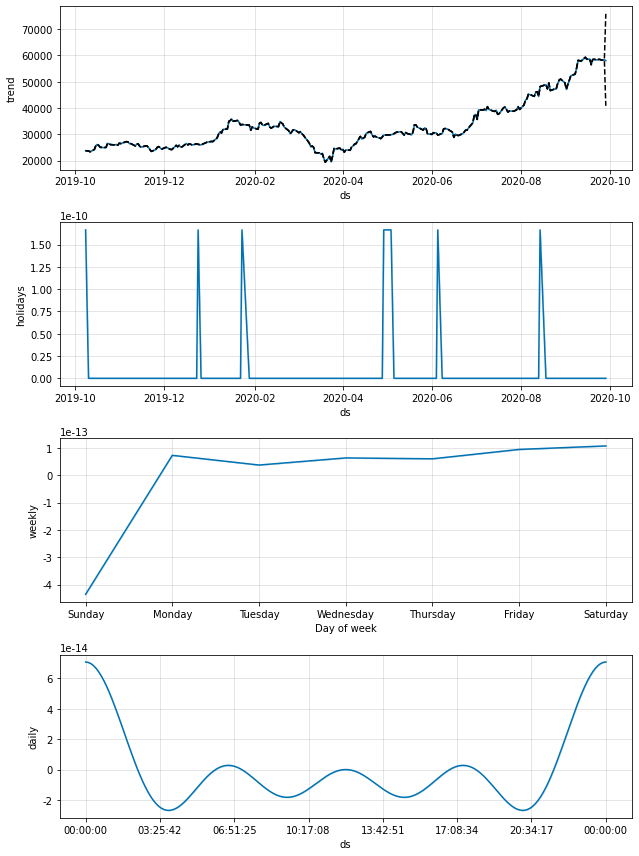

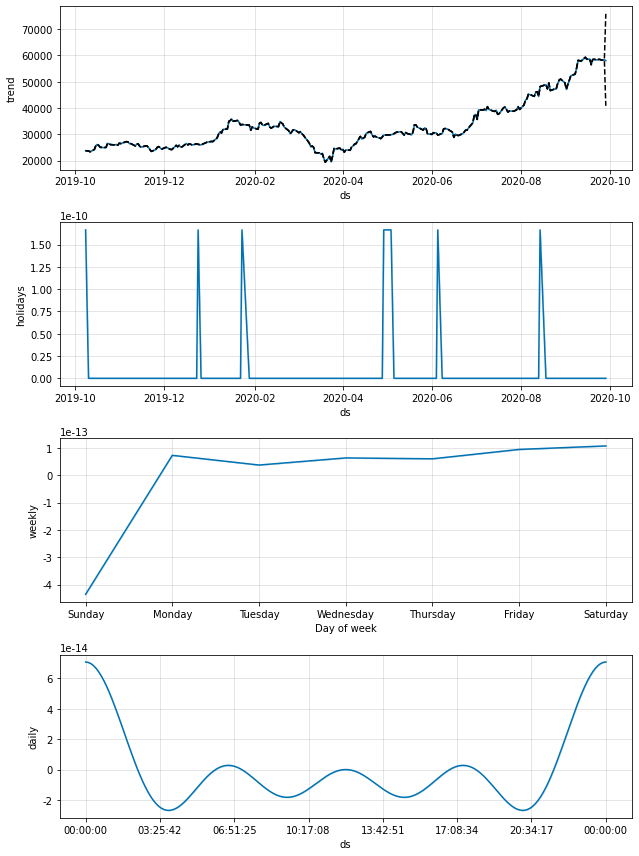

In [30]:
m.plot_components(forecast)

In [31]:
#fig = m.plot(forecast)
#a = add_changepoints_to_plot(fig.gca(), m, forecast)  # 빨간 실선은 트렌드

In [32]:
#for changepoint in m.changepoints:
#    plt.axvline(changepoint,ls='--', lw=1)

In [33]:

'''
Parameters
    ----------
    growth: String 'linear' or 'logistic' to specify a linear or logistic
        trend.
    changepoints: List of dates at which to include potential changepoints. If
        not specified, potential changepoints are selected automatically.
    n_changepoints: Number of potential changepoints to include. Not used
        if input `changepoints` is supplied. If `changepoints` is not supplied,
        then n_changepoints potential changepoints are selected uniformly from
        the first `changepoint_range` proportion of the history.
    changepoint_range: Proportion of history in which trend changepoints will
        be estimated. Defaults to 0.8 for the first 80%. Not used if
        `changepoints` is specified.
    yearly_seasonality: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    weekly_seasonality: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    daily_seasonality: Fit daily seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    holidays: pd.DataFrame with columns holiday (string) and ds (date type)
        and optionally columns lower_window and upper_window which specify a
        range of days around the date to be included as holidays.
        lower_window=-2 will include 2 days prior to the date as holidays. Also
        optionally can have a column prior_scale specifying the prior scale for
        that holiday.
    seasonality_mode: 'additive' (default) or 'multiplicative'.
    seasonality_prior_scale: Parameter modulating the strength of the
        seasonality model. Larger values allow the model to fit larger seasonal
        fluctuations, smaller values dampen the seasonality. Can be specified
        for individual seasonalities using add_seasonality.
    holidays_prior_scale: Parameter modulating the strength of the holiday
        components model, unless overridden in the holidays input.
    changepoint_prior_scale: Parameter modulating the flexibility of the
        automatic changepoint selection. Large values will allow many
        changepoints, small values will allow few changepoints.
    mcmc_samples: Integer, if greater than 0, will do full Bayesian inference
        with the specified number of MCMC samples. If 0, will do MAP
        estimation.
    interval_width: Float, width of the uncertainty intervals provided
        for the forecast. If mcmc_samples=0, this will be only the uncertainty
        in the trend using the MAP estimate of the extrapolated generative
        model. If mcmc.samples>0, this will be integrated over all model
        parameters, which will include uncertainty in seasonality.
    uncertainty_samples: Number of simulated draws used to estimate
        uncertainty intervals. Settings this value to 0 or False will disable
        uncertainty estimation and speed up the calculation.
    stan_backend: str as defined in StanBackendEnum default: None - will try to
        iterate over all available backends and find the working one
    """
'''

'\nParameters\n    ----------\n    growth: String \'linear\' or \'logistic\' to specify a linear or logistic\n        trend.\n    changepoints: List of dates at which to include potential changepoints. If\n        not specified, potential changepoints are selected automatically.\n    n_changepoints: Number of potential changepoints to include. Not used\n        if input `changepoints` is supplied. If `changepoints` is not supplied,\n        then n_changepoints potential changepoints are selected uniformly from\n        the first `changepoint_range` proportion of the history.\n    changepoint_range: Proportion of history in which trend changepoints will\n        be estimated. Defaults to 0.8 for the first 80%. Not used if\n        `changepoints` is specified.\n    yearly_seasonality: Fit yearly seasonality.\n        Can be \'auto\', True, False, or a number of Fourier terms to generate.\n    weekly_seasonality: Fit weekly seasonality.\n        Can be \'auto\', True, False, or a number o